### Load clsses/functions

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import trimesh
from skimage import measure
import meshplot as mp
from torch.utils.data import DataLoader, Dataset
import os
import time
from datetime import timedelta, datetime
import random
import math
from itertools import chain as chain
import pandas as pd

### Plot loss progression (All shapes)

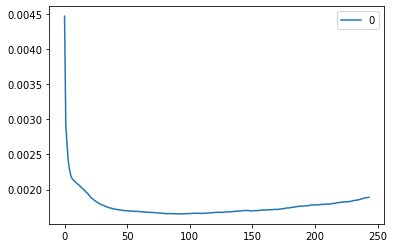

In [ ]:
df_gaudi = pd.read_csv('./models/autodecoder_08182022_200131.csv', header=None)
df_gaudi.plot()
plt.show()

In [ ]:
print(df_gaudi[0].idxmin())
df_gaudi.sort_values(by=0)

92


,0
92,0.001653
89,0.001653
95,0.001653
94,0.001654
91,0.001655
...,...
4,0.002280
3,0.002398
2,0.002646
1,0.002920


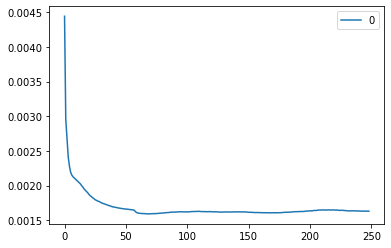

In [ ]:
df = pd.read_csv('./models/autodecoder_08182022_181516.csv', header=None)
df.plot()
plt.show()

In [ ]:
print(df[0].idxmin())
df.sort_values(by=0)

69


,0
69,0.001590
67,0.001591
68,0.001592
70,0.001592
66,0.001593
...,...
4,0.002278
3,0.002413
2,0.002686
1,0.002955


In [56]:
lost = []
        
with open("nongaudi.txt") as file:
    for i, line in enumerate(file):
        if i%4 == 0:
            lost.append(float(line.split()[4]))
lost = np.array(lost)
plt.plot( range(30, len(lost)+30), lost)

FileNotFoundError: [Errno 2] No such file or directory: 'nongaudi.txt'

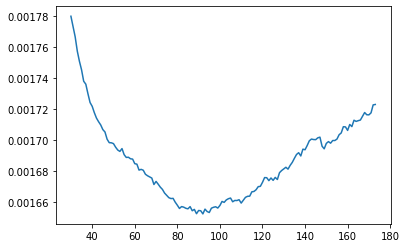

In [ ]:
lost = []
with open("gaudi.txt") as file:
    for line in file:
        lost.append(float(line.split()[4]))
lost = np.array(lost)
plt.plot(range(30, len(lost[30:])+30), lost[30:])

### Plot loss progression (500 shapes)

In [ ]:
# running on the modified code (tanh + weight norm + drop out + reg from 100 + reg same as the source)
'./models/autodecoder_09072022_194022(10 shapes).csv'
'./models/autodecoder_09072022_202723(500 shapes).csv'
'./models/autodecoder_09082022_040427(SGD).csv'
'./models/autodecoder_09082022_043128(Adam with both lr).csv'
'./models/autodecoder_09082022_201017(SGD,1e-4,1e-3).csv'
'./models/autodecoder_09082022_202110_364' # (Adam with higher lr: 1e-4, 1e-4, default betas eps)


# running on the modified2 code (shape code initializations std modified)
'./models/autodecoder_09092022_074022' # (Adam with higher lr: 1e-4, 1e-4, batch size 10 -> 64, subsample size 2048->16384)



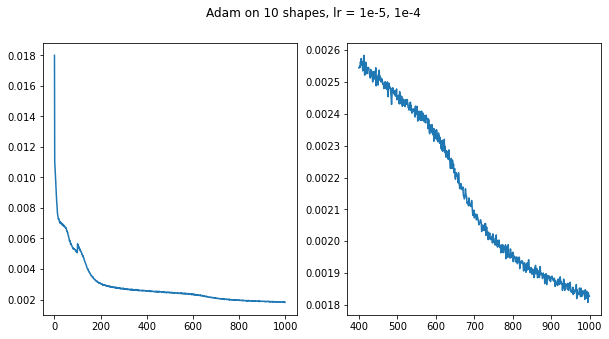

In [33]:
df = pd.read_csv('./models/autodecoder_09072022_194022(10 shapes).csv', header=None)
title = 'Adam on 10 shapes, lr = 1e-5, 1e-4'

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(title)
axs[0].plot(df)
axs[1].plot(df[400:])
plt.show()

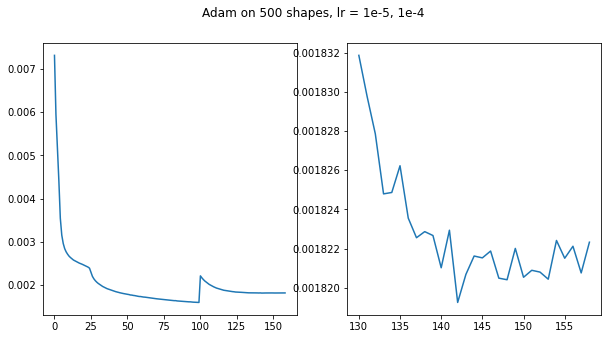

In [37]:
df = pd.read_csv('./models/autodecoder_09072022_202723(500 shapes).csv', header=None)

title = 'Adam on 500 shapes, lr = 1e-5, 1e-4'

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(title)
axs[0].plot(df)
axs[1].plot(df[130:])
plt.show()

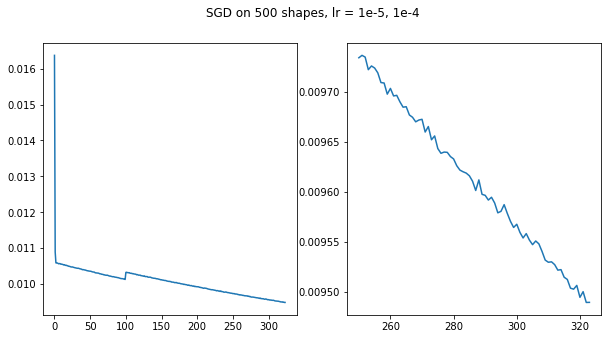

In [41]:
df = pd.read_csv('./models/autodecoder_09082022_040427(SGD).csv', header=None)
title = 'SGD on 500 shapes, lr = 1e-5, 1e-4'

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(title)
axs[0].plot(df)
axs[1].plot(df[250:])
plt.show()

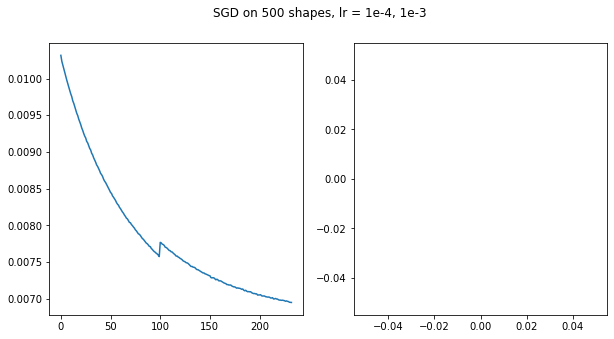

In [38]:
df = pd.read_csv('./models/autodecoder_09082022_201017(SGD,1e-4,1e-3).csv', header=None)
title = 'SGD on 500 shapes, lr = 1e-4, 1e-3'

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(title)
axs[0].plot(df)
axs[1].plot(df[250:])
plt.show()

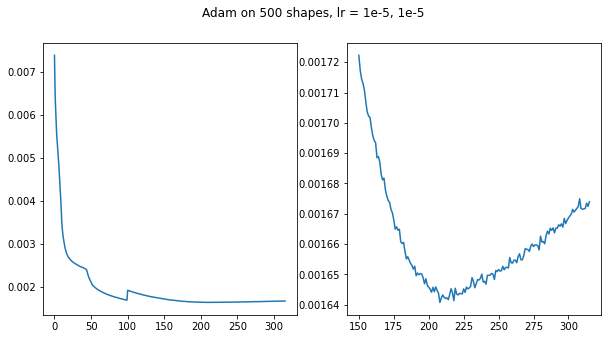

In [36]:
df = pd.read_csv('./models/autodecoder_09082022_043128(Adam with both lr).csv', header=None)
title = 'Adam on 500 shapes, lr = 1e-5, 1e-5'

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(title)
axs[0].plot(df)
axs[1].plot(df[150:])
plt.show()

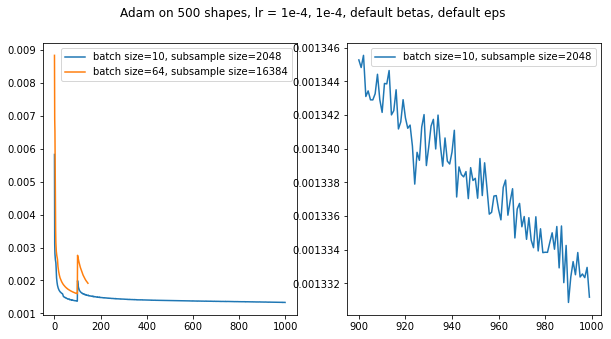

In [39]:
# 1. higher learning rate
# 2. default betas
# 3. default eps
df1 = pd.read_csv('./models/09082022_202110/autodecoder_09082022_202110.csv', header=None)# (Adam with higher lr: 1e-4, 1e-4, default betas eps)
df2 = pd.read_csv('./models/09092022_074022/autodecoder_09092022_074022.csv', header=None) # (Adam with higher lr: 1e-4, 1e-4, batch size 10 -> 64, subsample size 2048->16384)

title = 'Adam on 500 shapes, lr = 1e-4, 1e-4, default betas, default eps'

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(title)
axs[0].plot(df1, label="batch size=10, subsample size=2048")
axs[0].plot(df2, label="batch size=64, subsample size=16384")
axs[0].legend()
axs[1].plot(df1[900:1000], label="batch size=10, subsample size=2048")
axs[1].legend()


plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


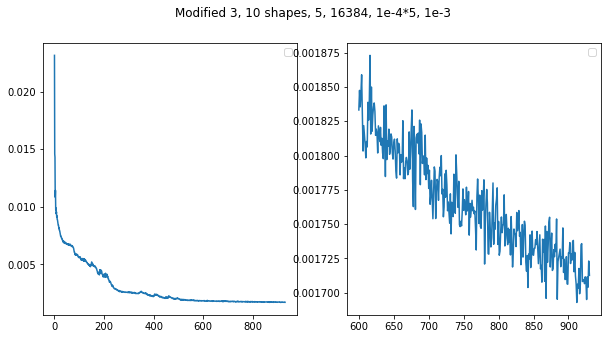

In [46]:
# embedding stored outside the model.

df = pd.read_csv('./models/09092022_191703/autodecoder_09092022_191703.csv', header=None) # (Adam with higher lr: 1e-4, 1e-4, batch size 10 -> 64, subsample size 2048->16384)

title = 'Modified 3, 10 shapes, 5, 16384, 1e-4*5, 1e-3'

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(title)
axs[0].plot(df)
axs[0].legend()
axs[1].plot(df[600:])
axs[1].legend()


plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


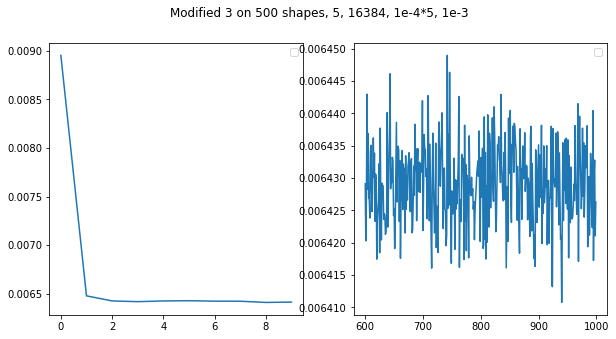

In [45]:


df = pd.read_csv('./models/09102022_011404/autodecoder_09102022_011404.csv', header=None) # (Adam with higher lr: 1e-4, 1e-4, batch size 10 -> 64, subsample size 2048->16384)

title = 'Modified 3, 500 shapes, 5, 16384, 1e-4*5, 1e-3'

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(title)
axs[0].plot(df[:10])
axs[0].legend()
axs[1].plot(df[600:])
axs[1].legend()


plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


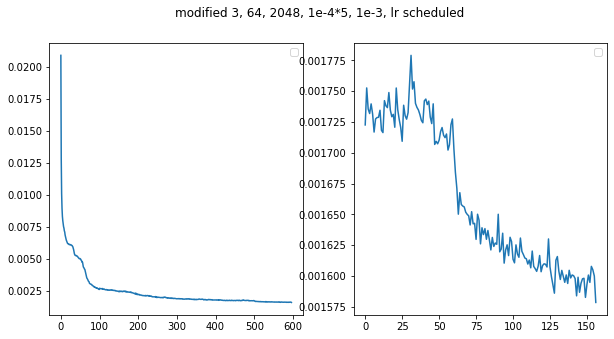

In [51]:

infile = './models/09122022_133838/autodecoder_09122022_133838.log'

loss_progress = []

with open(infile) as f:
    f = f.readlines()

for line in f:
    if "loss" in line and 'Validation' not in line:
        loss = line.split(' = ')[1]
        loss_progress.append(float(loss))
        
loss_progress = np.array(loss_progress)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('modified 3, 64, 2048, 1e-4*5, 1e-3, lr scheduled')
axs[0].plot(loss_progress)
axs[0].legend()
axs[1].plot(loss_progress[440:])
axs[1].legend()


plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


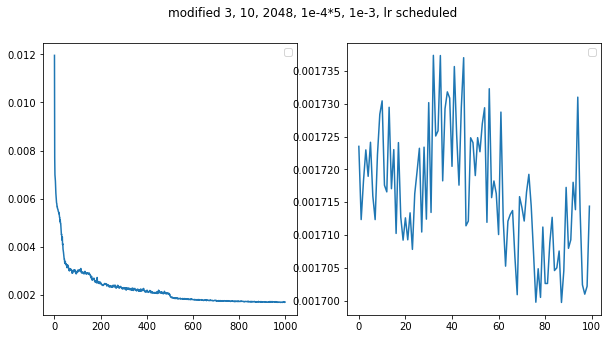

In [66]:

infile = './models/09122022_142320/autodecoder_09122022_142320.log'

loss_progress = []

with open(infile) as f:
    f = f.readlines()

for line in f:
    if "loss" in line and 'Validation' not in line:
        loss = line.split(' = ')[1]
        loss_progress.append(float(loss))
        
loss_progress = np.array(loss_progress)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('modified 3, 10, 2048, 1e-4*5, 1e-3, lr scheduled')
axs[0].plot(loss_progress)
axs[0].legend()
axs[1].plot(loss_progress[900:])
axs[1].legend()


plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


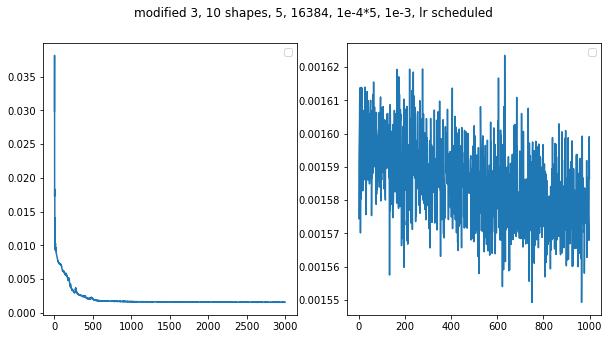

In [100]:
infile = './models/09132022_072139/autodecoder_09132022_072139.log'

loss_progress = []

with open(infile) as f:
    f = f.readlines()

for line in f:
    if "loss" in line and 'Validation' not in line:
        loss = line.split(' = ')[1]
        loss_progress.append(float(loss))
        
loss_progress = np.array(loss_progress)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('modified 3, 10 shapes, 5, 16384, 1e-4*5, 1e-3, lr scheduled')
axs[0].plot(loss_progress)
axs[0].legend()
axs[1].plot(loss_progress[2000:])
axs[1].legend()


plt.show()

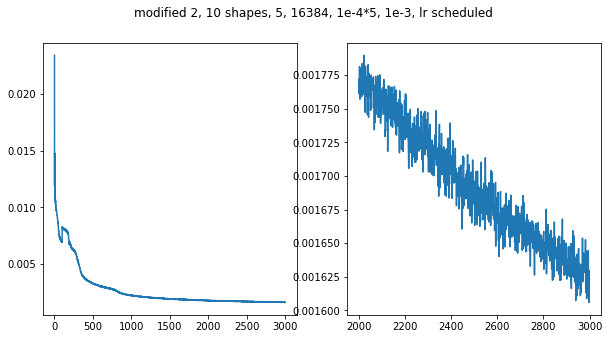

In [122]:
infile = './models/09132022_083657/autodecoder_09132022_083657.csv'


df = pd.read_csv(infile, header=None) # (Adam with higher lr: 1e-4, 1e-4, batch size 10 -> 64, subsample size 2048->16384)

title = 'modified 2, 10 shapes, 5, 16384, 1e-4*5, 1e-3, lr scheduled'

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(title)
axs[0].plot(df)
axs[1].plot(df[2000:])


plt.show()

In [24]:
infile = './models/09132022_163907/autodecoder_09132022_163907_2999.log'

loss_progress = []

with open(infile) as f:
    f = f.readlines()

for line in f:
    if "loss" in line and 'Validation' not in line:
        loss = line.split(' = ')[1]
        loss_progress.append(float(loss))
        
loss_progress = np.array(loss_progress)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('modified 3, 1 shapes, 1, 16384, 1e-4*5, 1e-3, lr scheduled')
axs[0].plot(loss_progress)
axs[0].legend()
axs[1].plot(loss_progress[2000:])
axs[1].legend()


plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './models/09132022_163907/autodecoder_09132022_163907_2999.log'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


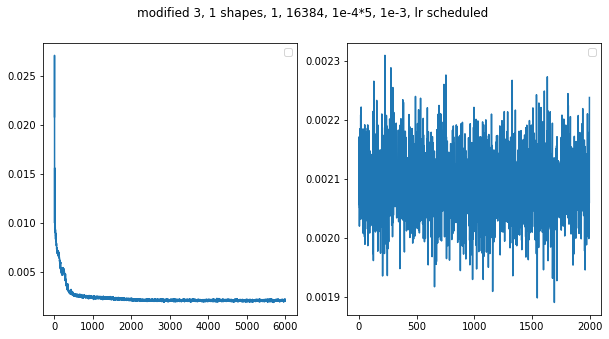

In [38]:
infile = './models/09142022_063051/autodecoder_09142022_063051.log'

loss_progress = []

with open(infile) as f:
    f = f.readlines()

for line in f:
    if "loss" in line and 'Validation' not in line:
        loss = line.split(' = ')[1]
        loss_progress.append(float(loss))
        
loss_progress = np.array(loss_progress)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('modified 3, 1 shapes, 1, 16384, 1e-4*5, 1e-3, lr scheduled')
axs[0].plot(loss_progress)
axs[0].legend()
axs[1].plot(loss_progress[4000:])
axs[1].legend()


plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


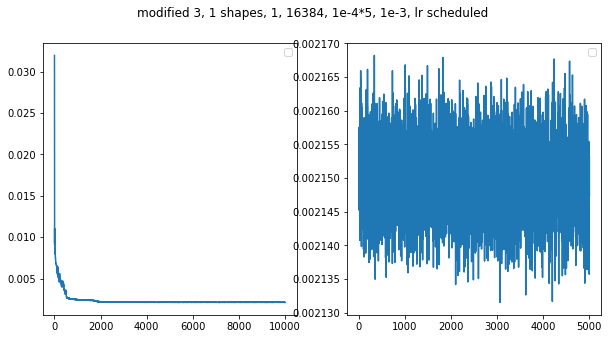

In [6]:
infile = './models/09142022_073400/autodecoder_09142022_073400.log'

loss_progress = []

with open(infile) as f:
    f = f.readlines()

for line in f:
    if "loss" in line and 'Validation' not in line:
        loss = line.split(' = ')[1]
        loss_progress.append(float(loss))
        
loss_progress = np.array(loss_progress)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('modified 3, 1 shapes, 1, 16384, 1e-4*5, 1e-3, lr scheduled')
axs[0].plot(loss_progress)
axs[0].legend()
axs[1].plot(loss_progress[5000:])
axs[1].legend()


plt.show()


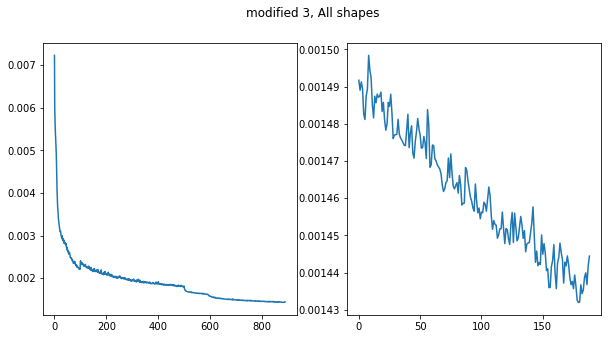

In [83]:
infile = './models/09142022_095844/autodecoder_09142022_095844.log'

loss_progress = []

with open(infile) as f:
    f = f.readlines()

for line in f:
    if "loss" in line and 'Validation' not in line:
        loss = line.split(' = ')[1]
        loss_progress.append(float(loss))
        
loss_progress = np.array(loss_progress)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('modified 3, All shapes')
axs[0].plot(loss_progress)
axs[1].plot(loss_progress[700:])

plt.show()


### Plotting weights/bias progression

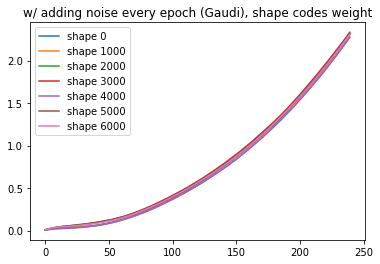

In [5]:
weights = []
shape_codes_mean = []
for i in range(240):
    filename = f'./models/autodecoder_08182022_200131_{i}'
    model = MLP(6778, 256, 512)
    model.load_state_dict(torch.load(filename))
    mean = np.resize(np.mean(np.absolute(model.state_dict()['shape_codes.weight'].detach().numpy()), axis=1), [1, 6778])
    shape_codes_mean.append(mean)
shape_codes_mean2 = np.concatenate(shape_codes_mean, 0)

plt.plot(shape_codes_mean2[:,0], label = "shape 0")
plt.plot(shape_codes_mean2[:,1000], label = "shape 1000")
plt.plot(shape_codes_mean2[:,2000], label = "shape 2000")
plt.plot(shape_codes_mean2[:,3000], label = "shape 3000")
plt.plot(shape_codes_mean2[:,4000], label = "shape 4000")
plt.plot(shape_codes_mean2[:,5000], label = "shape 5000")
plt.plot(shape_codes_mean2[:,6000], label = "shape 6000")

plt.legend()
plt.title('w/ adding noise every epoch (Gaudi), shape codes weight')
plt.show()


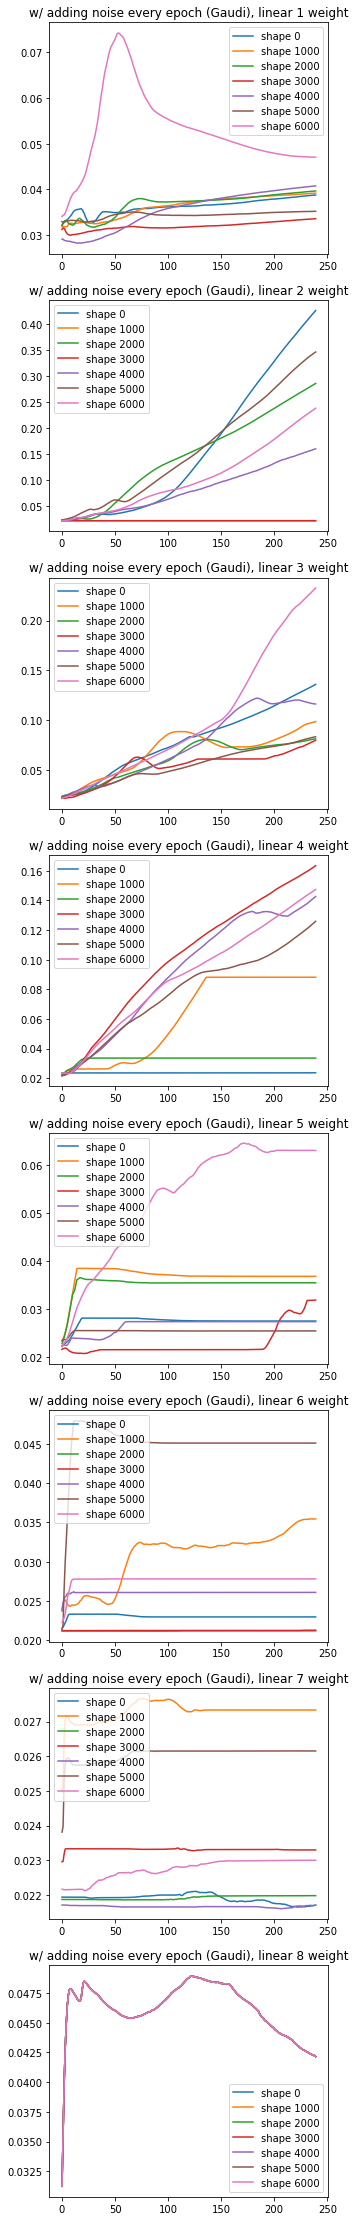

In [23]:
weights = []
linear1 = []
linear2 = []
linear3 = []
linear4 = []
linear5 = []
linear6 = []
linear7 = []
linear8 = []

for i in range(240):
    filename = f'./models/autodecoder_08182022_200131_{i}'
    model = MLP(6778, 256, 512)
    model.load_state_dict(torch.load(filename))
    linear1.append(np.resize(np.mean(np.absolute(model.state_dict()['linear1.weight'].detach().numpy()), axis=1), [1, 6778]))
    linear2.append(np.resize(np.mean(np.absolute(model.state_dict()['linear2.weight'].detach().numpy()), axis=1), [1, 6778]))
    linear3.append(np.resize(np.mean(np.absolute(model.state_dict()['linear3.weight'].detach().numpy()), axis=1), [1, 6778]))
    linear4.append(np.resize(np.mean(np.absolute(model.state_dict()['linear4.weight'].detach().numpy()), axis=1), [1, 6778]))
    linear5.append(np.resize(np.mean(np.absolute(model.state_dict()['linear5.weight'].detach().numpy()), axis=1), [1, 6778]))
    linear6.append(np.resize(np.mean(np.absolute(model.state_dict()['linear6.weight'].detach().numpy()), axis=1), [1, 6778]))
    linear7.append(np.resize(np.mean(np.absolute(model.state_dict()['linear7.weight'].detach().numpy()), axis=1), [1, 6778]))
    linear8.append(np.resize(np.mean(np.absolute(model.state_dict()['linear8.weight'].detach().numpy()), axis=1), [1, 6778]))
    
linear1 = np.concatenate(linear1, 0)
linear2 = np.concatenate(linear2, 0)
linear3 = np.concatenate(linear3, 0)
linear4 = np.concatenate(linear4, 0)
linear5 = np.concatenate(linear5, 0)
linear6 = np.concatenate(linear6, 0)
linear7 = np.concatenate(linear7, 0)
linear8 = np.concatenate(linear8, 0)

figure, axis = plt.subplots(8, 1, figsize=(5, 40))

for i in [1, 2, 3, 4, 5, 6, 7, 8]:
    linear = []
    if (i == 1): linear = linear1
    elif (i == 2): linear = linear2
    elif i == 3: linear = linear3
    elif i == 4: linear = linear4
    elif i == 5: linear = linear5
    elif i == 6: linear = linear6
    elif i == 7: linear = linear7
    elif i == 8: linear = linear8
    else: continue
    
    axis[i-1].plot(linear[:,0], label = "shape 0")
    axis[i-1].plot(linear[:,1000], label = "shape 1000")
    axis[i-1].plot(linear[:,2000], label = "shape 2000")
    axis[i-1].plot(linear[:,3000], label = "shape 3000")
    axis[i-1].plot(linear[:,4000], label = "shape 4000")
    axis[i-1].plot(linear[:,5000], label = "shape 5000")
    axis[i-1].plot(linear[:,6000], label = "shape 6000")
    axis[i-1].set_title(f'w/ adding noise every epoch (Gaudi), linear {i} weight')
    axis[i-1].legend()


plt.show()






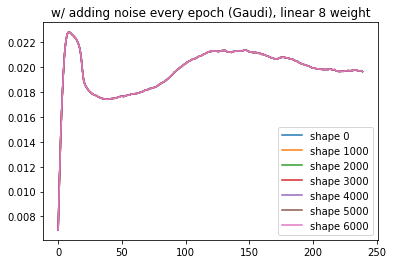

In [165]:
weights = []
shape_codes_mean = []
for i in range(240):
    filename = f'./models/autodecoder_08182022_200131_{i}'
    model = MLP(6778, 256, 512)
    model.load_state_dict(torch.load(filename))
    mean = np.resize(np.mean(model.state_dict()['linear8.weight'].detach().numpy(), axis=1), [1, 6778])
    shape_codes_mean.append(mean)
shape_codes_mean2 = np.concatenate(shape_codes_mean, 0)

plt.plot(shape_codes_mean2[:,0], label = "shape 0")
plt.plot(shape_codes_mean2[:,1000], label = "shape 1000")
plt.plot(shape_codes_mean2[:,2000], label = "shape 2000")
plt.plot(shape_codes_mean2[:,3000], label = "shape 3000")
plt.plot(shape_codes_mean2[:,4000], label = "shape 4000")
plt.plot(shape_codes_mean2[:,5000], label = "shape 5000")
plt.plot(shape_codes_mean2[:,6000], label = "shape 6000")

plt.legend()
plt.title('w/ adding noise every epoch (Gaudi), linear 8 weight')
plt.show()


weights = []
shape_codes_mean = []
for i in range(240):
    filename = f'./models/autodecoder_08182022_181516_{i}'
    model = MLP(6778, 256, 512)
    model.load_state_dict(torch.load(filename))
    mean = np.resize(np.mean(np.absolute(model.state_dict()['shape_codes.weight'].detach().numpy()), axis=1), [1, 6778])
    shape_codes_mean.append(mean)
shape_codes_mean2 = np.concatenate(shape_codes_mean, 0)

plt.plot(shape_codes_mean2[:,0], label = "shape 0")
plt.plot(shape_codes_mean2[:,1000], label = "shape 1000")
plt.plot(shape_codes_mean2[:,2000], label = "shape 2000")
plt.plot(shape_codes_mean2[:,3000], label = "shape 3000")
plt.plot(shape_codes_mean2[:,4000], label = "shape 4000")
plt.plot(shape_codes_mean2[:,5000], label = "shape 5000")
plt.plot(shape_codes_mean2[:,6000], label = "shape 6000")

plt.legend()
plt.title('w/o adding noise every epoch, shape codes weight')
plt.show()


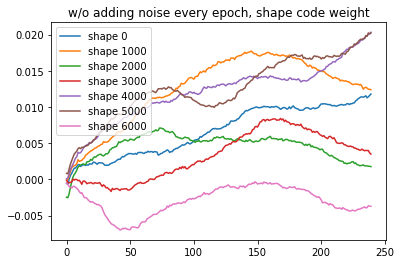

In [166]:
weights = []
shape_codes_mean = []
for i in range(240):
    filename = f'./models/autodecoder_08182022_181516_{i}'
    model = MLP(6778, 256, 512)
    model.load_state_dict(torch.load(filename))
    mean = np.resize(np.mean(model.state_dict()['shape_codes.weight'].detach().numpy(), axis=1), [1, 6778])
    shape_codes_mean.append(mean)
shape_codes_mean2 = np.concatenate(shape_codes_mean, 0)

plt.plot(shape_codes_mean2[:,0], label = "shape 0")
plt.plot(shape_codes_mean2[:,1000], label = "shape 1000")
plt.plot(shape_codes_mean2[:,2000], label = "shape 2000")
plt.plot(shape_codes_mean2[:,3000], label = "shape 3000")
plt.plot(shape_codes_mean2[:,4000], label = "shape 4000")
plt.plot(shape_codes_mean2[:,5000], label = "shape 5000")
plt.plot(shape_codes_mean2[:,6000], label = "shape 6000")

plt.legend()
plt.title('w/o adding noise every epoch, shape code weight')
plt.show()

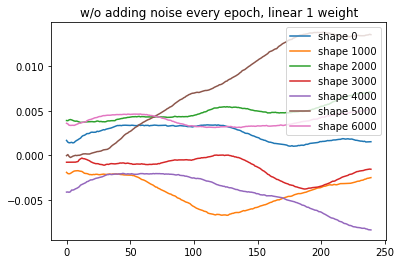

In [167]:
weights = []
shape_codes_mean = []
for i in range(240):
    filename = f'./models/autodecoder_08182022_181516_{i}'
    model = MLP(6778, 256, 512)
    model.load_state_dict(torch.load(filename))
    mean = np.resize(np.mean(model.state_dict()['linear1.weight'].detach().numpy(), axis=1), [1, 6778])
    shape_codes_mean.append(mean)
shape_codes_mean2 = np.concatenate(shape_codes_mean, 0)

plt.plot(shape_codes_mean2[:,0], label = "shape 0")
plt.plot(shape_codes_mean2[:,1000], label = "shape 1000")
plt.plot(shape_codes_mean2[:,2000], label = "shape 2000")
plt.plot(shape_codes_mean2[:,3000], label = "shape 3000")
plt.plot(shape_codes_mean2[:,4000], label = "shape 4000")
plt.plot(shape_codes_mean2[:,5000], label = "shape 5000")
plt.plot(shape_codes_mean2[:,6000], label = "shape 6000")

plt.legend()
plt.title('w/o adding noise every epoch, linear 1 weight')
plt.show()

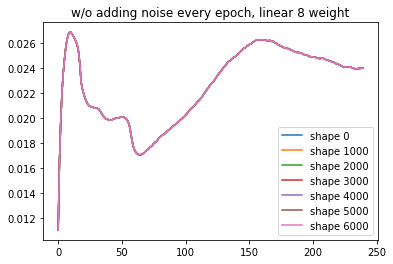

In [169]:
weights = []
shape_codes_mean = []
for i in range(240):
    filename = f'./models/autodecoder_08182022_181516_{i}'
    model = MLP(6778, 256, 512)
    model.load_state_dict(torch.load(filename))
    mean = np.resize(np.mean(model.state_dict()['linear8.weight'].detach().numpy(), axis=1), [1, 6778])
    shape_codes_mean.append(mean)
shape_codes_mean2 = np.concatenate(shape_codes_mean, 0)

plt.plot(shape_codes_mean2[:,0], label = "shape 0")
plt.plot(shape_codes_mean2[:,1000], label = "shape 1000")
plt.plot(shape_codes_mean2[:,2000], label = "shape 2000")
plt.plot(shape_codes_mean2[:,3000], label = "shape 3000")
plt.plot(shape_codes_mean2[:,4000], label = "shape 4000")
plt.plot(shape_codes_mean2[:,5000], label = "shape 5000")
plt.plot(shape_codes_mean2[:,6000], label = "shape 6000")

plt.legend()
plt.title('w/o adding noise every epoch, linear 8 weight')
plt.show()

### Plotting inferred shapes

In [52]:
# filename = './models/autodecoder_08052022_073446' # loading one point at a time
# model = MLP_old(10, 256, 256)
# filename = './models/autodecoder_08122022_202902' # loading multiple points at a time, 8 layers
# model = MLP(10, 256, 512)
# filename = './models/autodecoder_08122022_234636' # loading multiple points at a time, 3 layers, extra permutation
# model = MLP_old(10, 256, 256)
# filename = './models/autodecoder_08132022_003242' # loading multiple points at a time, 4 layers, extra permutation, 
# model = MLP_old(10, 256, 256)
# filename = './models/autodecoder_08132022_011401' # loading multiple points at a time, 4 layers, extra permutation, rigor=5 
# model = MLP_old(10, 256, 256)
# filename = './models/autodecoder_08132022_041952' # loading multiple points at a time, 8 layers, 16 shapes, extra permutation, rigor=5 
# model = MLP(16, 256, 512)
# filename = './models/autodecoder_08132022_170026' # loading multiple points at a time, 8 layers, 16 shapes, extra permutation, rigor=2, w.o clamping 
# model = MLP(16, 256, 512)
# filename = './models/autodecoder_08132022_190738' # loading 1024 points at a time, 8 layers, 6778 shapes, extra permutation, up to epoch 1813, without clamping
# model = MLP(6778, 256, 512)
# filename = './models/autodecoder_08142022_121303 # loading 1024 points at a time, 8 layers, 6778 shapes, extra permutation, up to epoch 1813, clamping + L1loss
# model = MLP(6778, 256, 512)
# 08142022_231250 # tanh, training loss increased
# model = MLP(6778, 256, 512)
# 08182022_105030 # remove max_norm, initialization only, regularization param: sigma = 1e2
# model = MLP(6778, 256, 512)
# 08182022_105028 # remove max_norm, initialization only, regularization param: sigma = 1e-2
# model = MLP(6778, 256, 512)
# 08182022_172451 # rerun on 10 shapes with the most updated network
# model = MLP(10, 256, 256)


#### embedding inside the decoder model

In [3]:
from train_decoder_modified2 import MLP
model = MLP(10, 256, 512)
model.load_state_dict(torch.load('./models/09132022_083657/autodecoder_09132022_083657_2999'))
model.eval()

x = np.linspace(-1, 1, 200, dtype=np.float32)
y = np.linspace(-1, 1, 200, dtype=np.float32)
z = np.linspace(-1, 1, 200, dtype=np.float32)
P = np.vstack(np.meshgrid(x,y,z)).reshape(3,-1).T  # format: [[x1, y1, z1], [x1, y1, z2], [] ...]
P = torch.from_numpy(P)
P = torch.chunk(P, 100)

shape_idx = 9
sdfs = []

for idx, points in enumerate(P):
    print(idx)
    points = points.view(-1, 3)
    shape_indices = torch.ones((points.shape[0]), dtype=torch.long) * shape_idx
    sdfs.append(model(shape_indices, points).detach().numpy())
sdfs = np.concatenate(sdfs, axis=0)
sdfs = np.resize(sdfs, (len(x), len(y), len(z))) 
verts, faces, normals, values = measure.marching_cubes(sdfs, 0)
mp.plot(verts, faces)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


/home/paulaugguerrero_gmail_com/miniconda3/lib/python3.9/site-packages/jupyter_client/session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(95.499944…

#### embedding outside the decoder model

In [36]:
def process_log_for_plotting(datetime):
    with open(os.path.join('./models/', datetime, f'autodecoder_{datetime}.log')) as f:
        f = f.readlines()

    for line in f:
        if "load_all_shapes" in line:
            load_all_shapes = line.split(' = ')[1].split(',')[0].strip()
        if "n_shapes" in line:
            n_shapes = line.split(' = ')[2].split(',')[0].strip()
        if load_all_shapes == 'True':
            n_shapes = 6778
        if "dropout" in line:
            dropout = line.split('=')[3].split(',')[0].strip()
        if "weight_norm" in line:
            weight_norm = line.split('=')[5].split(',')[0].strip()
        if "use_tanh" in line:
            use_tanh = line.split('=')[6].strip()
        if "n_points_to_load" in line:
            n_points_to_load = line.split(' = ')[2].split(',')[0].strip()
        if "loss" in line and 'Validation' not in line:
            epoch_trained = line.split('-')[2].split('loss')[0].strip()
    
    return int(n_shapes), dropout=="True", weight_norm=="True", use_tanh=="use_tanh", int(epoch_trained)

def save_shapes(scale, offset, verts, faces, axis_limits, filename):
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    verts = verts * scale + offset

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    mesh = Poly3DCollection(verts[faces])
    mesh.set_edgecolor('k')
    ax.add_collection3d(mesh)

    ax.set_xlabel("x-axis")
    ax.set_ylabel("y-axis")
    ax.set_zlabel("z-axis")

    ax.set_xlim(axis_limits[0], axis_limits[1])
    ax.set_ylim(axis_limits[2], axis_limits[3])
    ax.set_zlim(axis_limits[4], axis_limits[5])

    plt.tight_layout()
    plt.savefig(filename)
    plt.close(fig)
    
def plot_shapes(datetime, epoch=None, shape_indices=[1, 1000], resolution=100, save_or_not=True, show_ground_truth_or_not=True):
    # get parameters used in training
    n_shapes, dropout, weight_norm, use_tanh, epoch_trained = process_log_for_plotting(datetime)
    if epoch is None:
        epoch = epoch_trained
    #TODO:auto-update epoch according to saved models
    
    # prepare models
    from train_decoder_modified3 import MLP
    model = MLP(n_shapes, 256, 512, dropout, 0.2, weight_norm, use_tanh)
    model.load_state_dict(torch.load(f'./models/{datetime}/autodecoder_{datetime}_{epoch}'))
    model.eval()

    shapecode = torch.nn.Embedding(n_shapes, 256)
    shapecode.load_state_dict(torch.load(f'./models/{datetime}/shapecode_{datetime}_{epoch}'))
    shapecode = shapecode.weight.data.detach()

    # prepare sampling points
    x = np.linspace(-1, 1, resolution, dtype=np.float32)
    y = np.linspace(-1, 1, resolution, dtype=np.float32)
    z = np.linspace(-1, 1, resolution, dtype=np.float32)
    P = np.vstack(np.meshgrid(x,y,z)).reshape(3,-1).T  # format: [[x1, y1, z1], [x1, y1, z2], [] ...]
    P = torch.from_numpy(P)
    P = torch.chunk(P, 100)
  
    scale = np.array([x[1] - x[0], y[1] - y[0], z[1] - z[0]])
    offset = np.array([x[0], y[0], z[0]]) #TODO: this should be computed based on the estimated bounds
    axis_limits = [x[0], x[-1], y[0], y[-1], z[0], z[-1]]
    
    # plot shapes
    for shape_index in shape_indices: #TODO: when no shape_indices input -> randomly select
        if shape_index > (n_shapes-1):
            continue
            
        print(f'plotting datetime={datetime}, n_shapes={n_shapes}, dropout={dropout}, weight_norm={weight_norm}, tanh={use_tanh}, epoch={epoch}(out of {epoch_trained}), shape index={shape_index}')
        sdfs = []
        for points in P:
            points = points.view(-1, 3)
            n_shape_index = torch.ones((points.shape[0]), dtype=torch.long) * shape_index
            shapecodes = shapecode[n_shape_index].view(-1, 256)
            sdfs.append(model(torch.cat((points, shapecodes), dim=1)).detach().numpy())
        sdfs = np.concatenate(sdfs, axis=0)
        sdfs = np.resize(sdfs, (len(x), len(y), len(z))) 
        verts, faces, normals, values = measure.marching_cubes(sdfs, 0)
        mp.plot(verts, faces)
        
        if save_or_not:
            filename = f'./models/{datetime}/{datetime}_{n_shapes}_{dropout}_{weight_norm}_{use_tanh}_{epoch}({epoch_trained})_{shape_index}.png'
            save_shapes(scale, offset, verts, faces, axis_limits, filename)
        if show_ground_truth_or_not:
            from train_decoder_modified3 import MLP
            file_paths=load_files(True)
            mesh = trimesh.load(file_paths[shape_index].split('sdf_samples.npz')[0] + 'mesh.obj')
            mp.plot(mesh.vertices, mesh.faces, c=np.array([0, 0.9, 0.9]))
            

In [37]:
plot_shapes('09152022_190445', shape_indices=[1001, 1002, 1003, 1004, 1005, 1006, 1007], epoch=2940)



plotting datetime=09152022_190445, n_shapes=6778, dropout=False, weight_norm=False, tanh=False, epoch=2940(out of 2945), shape index=1001


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(49.434279…

total # of files: 6778


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

plotting datetime=09152022_190445, n_shapes=6778, dropout=False, weight_norm=False, tanh=False, epoch=2940(out of 2945), shape index=1002


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(48.672395…

total # of files: 6778


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

plotting datetime=09152022_190445, n_shapes=6778, dropout=False, weight_norm=False, tanh=False, epoch=2940(out of 2945), shape index=1003


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(49.453402…

total # of files: 6778


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

plotting datetime=09152022_190445, n_shapes=6778, dropout=False, weight_norm=False, tanh=False, epoch=2940(out of 2945), shape index=1004


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(49.303160…

total # of files: 6778


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

plotting datetime=09152022_190445, n_shapes=6778, dropout=False, weight_norm=False, tanh=False, epoch=2940(out of 2945), shape index=1005


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(49.699037…

total # of files: 6778


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

plotting datetime=09152022_190445, n_shapes=6778, dropout=False, weight_norm=False, tanh=False, epoch=2940(out of 2945), shape index=1006


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(49.495950…

total # of files: 6778


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

plotting datetime=09152022_190445, n_shapes=6778, dropout=False, weight_norm=False, tanh=False, epoch=2940(out of 2945), shape index=1007


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(49.337747…

total # of files: 6778


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

### Plotting ground truth shapes

In [21]:
# from train_decoder_modified2 import load_files
def load_files(all_file_or_not, n_files = 0):
    file_paths = []
    main_dir = '../data/03001627_sdfs/'

    if all_file_or_not: # loading all files
        n_files = 0
        for sub_dir in os.scandir(main_dir):
            if sub_dir.is_dir():
                for file in os.listdir(main_dir + sub_dir.name):
                    file_paths.append(main_dir + sub_dir.name + '/' + file) if file == "sdf_samples.npz" else None
            n_files += 1
            
    else: # loading specific # of files
        for sub_dir in os.scandir(main_dir):
            if sub_dir.is_dir():
                for file in os.listdir(main_dir + sub_dir.name):
                    file_paths.append(main_dir + sub_dir.name + '/' + file) if file == "sdf_samples.npz" else None
            if len(file_paths) == n_files:
                break
    
    print(f'total # of files: {n_files}')
    return file_paths

file_paths=load_files(True)

for shape_idx in [1, 1000, 2000, 3000, 4000, 5000, 6000]:
    mesh = trimesh.load(file_paths[shape_idx].split('sdf_samples.npz')[0] + 'mesh.obj')
    mp.plot(mesh.vertices, mesh.faces, c=np.array([0, 0.9, 0.9]))

total # of files: 6778


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

### Plot saved plots

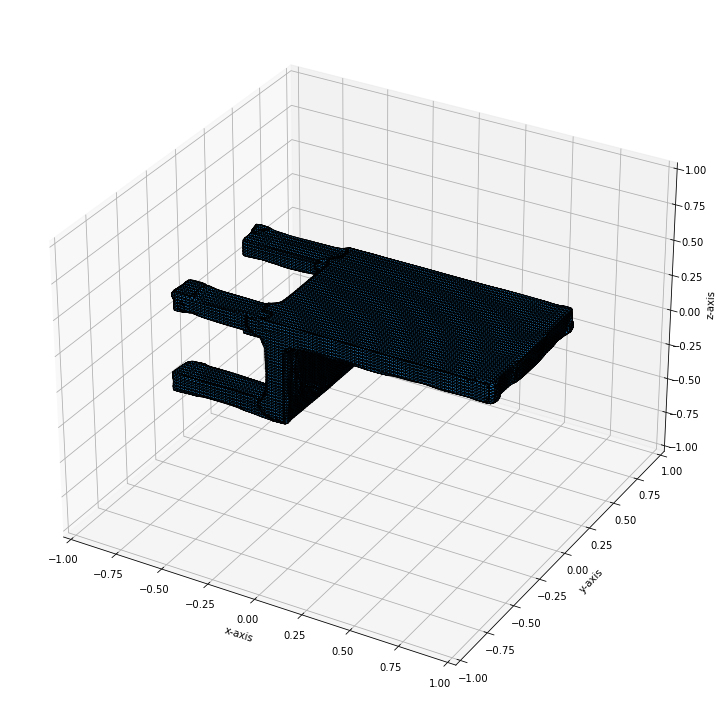

In [76]:
from IPython.display import Image, display
display(Image(filename='./models/09142022_095844/09142022_095844_6778_False_False_False_850(852)_3000.png'))